In [1]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

os.chdir(str(Path.cwd().parent))

%load_ext autoreload
%autoreload 1

%aimport src.data_preprocessing.data_loader
%aimport src.data_preprocessing.data_features
%aimport src.utils.setup_utilities


from src.data_preprocessing.data_loader import DataLoader
from src.data_preprocessing.data_features import FeatureExtractor
from src.utils.setup_utilities import load_config, setup_logging, load_data

In [2]:
config = load_config()
stock_data = load_data(config)
stock_data = stock_data.reset_index().set_index('Ticker')

stock_data['Log_Close'] = stock_data.groupby('Date')['Adj Close'].transform(lambda x: np.log(x))
stock_data['Diff_Log_Close'] = stock_data.groupby('Ticker')['Log_Close'].diff()

lag_periods = 5
for i in range(1, lag_periods + 1):
    stock_data[f'Diff_Log_Close_Lag_{i}'] = stock_data.groupby('Ticker')['Diff_Log_Close'].shift(i)


window_sizes = [5, 10, 20] 
for window_size in window_sizes:
    stock_data[f'Moving_Avg_Close_{window_size}'] = stock_data.groupby('Ticker')['Diff_Log_Close'].transform(lambda x: x.rolling(window=window_size).mean())
    
alphas = [0.2, 0.6, 0.8]  
for alpha in alphas:
    stock_data[f'Exp_Moving_Avg_Close_{alpha}'] = stock_data.groupby('Ticker')['Diff_Log_Close'].transform(lambda x: x.ewm(alpha=alpha, adjust=False).mean())

volatility_window_sizes = [5, 10, 15, 20]  
for volatility_window_size in volatility_window_sizes:
    stock_data[f'Std_Dev_Close_{volatility_window_size}'] = stock_data.groupby('Ticker')['Diff_Log_Close'].transform(lambda x: x.rolling(window=volatility_window_size).std())

stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data['Day'] = stock_data['Date'].dt.dayofweek
stock_data['Month'] = stock_data['Date'].dt.month
stock_data['Quarter'] = stock_data['Date'].dt.quarter


stock_data['DayOfWeek_sin'] = np.sin(2 * np.pi * stock_data['Day'] / 5).astype(np.float16)
stock_data['DayOfWeek_cos'] = np.cos(2 * np.pi * stock_data['Day'] / 5).astype(np.float16)

# Encode month
stock_data['Month_sin'] = np.sin(2 * np.pi * stock_data['Month'] / 12).astype(np.float16)
stock_data['Month_cos'] = np.cos(2 * np.pi * stock_data['Month'] / 12).astype(np.float16)

# Encode quarter
stock_data['Quarter_sin'] = np.sin(2 * np.pi * stock_data['Quarter'] / 4).astype(np.float16)
stock_data['Quarter_cos'] = np.cos(2 * np.pi * stock_data['Quarter'] / 4).astype(np.float16)

stock_data = stock_data.drop(['Day', 'Month', 'Quarter', 'Adj Close', 'Log_Close' ], axis=1)


stock_data = stock_data.reset_index().set_index(['Date', 'Ticker'])


stock_data = stock_data.dropna()

stock_data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,,Diff_Log_Close,Diff_Log_Close_Lag_1,Diff_Log_Close_Lag_2,Diff_Log_Close_Lag_3,Diff_Log_Close_Lag_4,Diff_Log_Close_Lag_5,Moving_Avg_Close_5,Moving_Avg_Close_10,Moving_Avg_Close_20,Exp_Moving_Avg_Close_0.2,...,Std_Dev_Close_5,Std_Dev_Close_10,Std_Dev_Close_15,Std_Dev_Close_20,DayOfWeek_sin,DayOfWeek_cos,Month_sin,Month_cos,Quarter_sin,Quarter_cos
Date,Ticker,,,,,,,,,,,,,,,,,,,,,
2013-01-31,MSFT,-0.014466,-0.005729,0.003577,0.001075,0.009008,0.000724,-0.001307,0.001505,-0.000309,-0.001610,...,0.009064,0.008633,0.008867,0.009602,-0.587891,-0.809082,0.500000,0.866211,1.0,0.0
2013-02-01,MSFT,0.017335,-0.014466,-0.005729,0.003577,0.001075,0.009008,0.000358,0.002465,0.001232,0.002179,...,0.011789,0.009850,0.009165,0.009846,-0.951172,0.309082,0.866211,0.500000,1.0,0.0
2013-02-04,MSFT,-0.017699,0.017335,-0.014466,-0.005729,0.003577,0.001075,-0.003397,0.000695,0.001292,-0.001797,...,0.014239,0.011749,0.010204,0.009720,0.000000,1.000000,0.866211,0.500000,1.0,0.0
2013-02-05,MSFT,0.002184,-0.017699,0.017335,-0.014466,-0.005729,0.003577,-0.003675,0.001281,0.001495,-0.001001,...,0.014081,0.011653,0.010203,0.009693,0.951172,0.309082,0.866211,0.500000,1.0,0.0
2013-02-06,MSFT,-0.005835,0.002184,-0.017699,0.017335,-0.014466,-0.005729,-0.003696,-0.000983,0.001466,-0.001968,...,0.014085,0.010438,0.009942,0.009715,0.587891,-0.809082,0.866211,0.500000,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,GOOGL,0.007591,0.014924,0.012292,0.006240,0.023846,0.004990,0.012978,0.004703,0.001726,0.007908,...,0.007014,0.010851,0.017845,0.016851,-0.951172,0.309082,-0.000000,1.000000,-0.0,1.0
2023-12-26,GOOGL,0.000212,0.007591,0.014924,0.012292,0.006240,0.023846,0.008252,0.005991,0.001839,0.006369,...,0.005700,0.009198,0.016582,0.016832,0.951172,0.309082,-0.000000,1.000000,-0.0,1.0
2023-12-27,GOOGL,-0.008159,0.000212,0.007591,0.014924,0.012292,0.006240,0.005372,0.005755,0.001142,0.003463,...,0.009404,0.009558,0.016837,0.016948,0.587891,-0.809082,-0.000000,1.000000,-0.0,1.0


In [3]:
variable_type = {
    'Lagged': ['Diff_Log_Close_Lag_1', 'Diff_Log_Close_Lag_2', 'Diff_Log_Close_Lag_3', 'Diff_Log_Close_Lag_4', 'Diff_Log_Close_Lag_5'],
    'Means': ['Moving_Avg_Close_5', 'Moving_Avg_Close_10', 'Moving_Avg_Close_20', 'Exp_Moving_Avg_Close_0.2', 'Exp_Moving_Avg_Close_0.6', 'Exp_Moving_Avg_Close_0.8',],
    'Volatility' : ['Std_Dev_Close_5', 'Std_Dev_Close_10', 'Std_Dev_Close_15', 'Std_Dev_Close_20'],  #'Lower_Band_20', 'Upper_Band_5', 'Lower_Band_5', 'Upper_Band_10', 'Lower_Band_10', 'Upper_Band_20'], 
    'Seasonal': ['DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin', 'Month_cos', 'Quarter_sin', 'Quarter_cos'],
    'Technical Indicators': [ 'Upper_Envelope', 'Lower_Envelope', 'Stoch_Oscillator',
                             'MACD', 'Signal_Line', 'Gain', 'Loss', 'Avg Gain', 'Avg Loss', 'RS', 'RSI']
}


from itertools import chain, combinations

# List of elements
elements = ['Lagged', 'Means', 'Volatility']

# Function to generate all possible combinations
def all_combinations(iterable):
    s = list(iterable)
    return [list(comb) for r in range(len(s) + 1) for comb in combinations(s, r) if comb]

combinations_list = all_combinations(elements)

print("All possible combinations:")
print(combinations_list)
print(len(combinations_list))

all_combinations = []

for combination in combinations_list:
    for i, c in enumerate(combination): 
        if i == 0: 
            current_combination = variable_type[c].copy()
        else: 
            current_combination.extend(variable_type[c].copy())
        
    
    all_combinations.append(current_combination)
    

shortest_combination = max(all_combinations, key=len)

combination_index_dict = {index: combination for index, combination in enumerate(all_combinations)}

# Now you can access the combination for a specific index like this:
# For example, if you want to get the combination for the shortest combination's index:
shortest_combination_index = all_combinations.index(shortest_combination)
shortest_combination_from_dict = combination_index_dict[shortest_combination_index]

print("Combination Index Dictionary:", combination_index_dict.keys())
print("Combination for Shortest Combination's Index:", shortest_combination_from_dict)

All possible combinations:
[['Lagged'], ['Means'], ['Volatility'], ['Lagged', 'Means'], ['Lagged', 'Volatility'], ['Means', 'Volatility'], ['Lagged', 'Means', 'Volatility']]
7
Combination Index Dictionary: dict_keys([0, 1, 2, 3, 4, 5, 6])
Combination for Shortest Combination's Index: ['Diff_Log_Close_Lag_1', 'Diff_Log_Close_Lag_2', 'Diff_Log_Close_Lag_3', 'Diff_Log_Close_Lag_4', 'Diff_Log_Close_Lag_5', 'Moving_Avg_Close_5', 'Moving_Avg_Close_10', 'Moving_Avg_Close_20', 'Exp_Moving_Avg_Close_0.2', 'Exp_Moving_Avg_Close_0.6', 'Exp_Moving_Avg_Close_0.8', 'Std_Dev_Close_5', 'Std_Dev_Close_10', 'Std_Dev_Close_15', 'Std_Dev_Close_20']


In [4]:
from gtda.time_series import SlidingWindow
from gtda.time_series import PearsonDissimilarity
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import Amplitude

stock_dataM = stock_data.xs('GOOGL', level='Ticker').copy()
stock_dataMA = stock_dataM.copy().tail(2739).reset_index()
y =  stock_dataM['Diff_Log_Close']



i = 1
for combination in combination_index_dict.keys(): 
    
    X = stock_dataM[combination_index_dict[combination]]
    
    n_features = len(combination_index_dict[combination])
    
    window_size = 10
    stride = 1

    SW = SlidingWindow(size=window_size, stride=stride)
    X_sw, yr = SW.fit_transform_resample(X, y)
    
    PD = PearsonDissimilarity()
    X_pd = PD.fit_transform(X_sw)
    VR = VietorisRipsPersistence(homology_dimensions = [0, 1], metric="precomputed")
    #X_pd = np.nan_to_num(X_pd, nan=0.)
    X_vr = VR.fit_transform(X_pd) 
    Ampl = Amplitude(metric = 'bottleneck' )
    X_a = Ampl.fit_transform(X_vr)
    
    X_a = pd.DataFrame({f'{combination}_D0_W{window_size}': X_a[:, 0], f'{combination}_D1_{window_size}': X_a[:, 1]})

    stock_dataMA = pd.merge(stock_dataMA, X_a, left_index=True, right_index=True)


for combination in combination_index_dict.keys(): 
    X = stock_dataM[combination_index_dict[combination]]

    n_features = len(combination_index_dict[combination])
    
    window_size = 5
    stride = 1

    SW = SlidingWindow(size=window_size, stride=stride)
    X_sw, yr = SW.fit_transform_resample(X, y)
    
    PD = PearsonDissimilarity()
    X_pd = PD.fit_transform(X_sw)
    VR = VietorisRipsPersistence(homology_dimensions = [0, 1], metric="precomputed")
    X_vr = VR.fit_transform(X_pd) 
    Ampl = Amplitude(metric = 'bottleneck' )
    X_a = Ampl.fit_transform(X_vr)
    
    X_a = pd.DataFrame({f'{combination}_D0_W{window_size}': X_a[:, 0], f'{combination}_D1_{window_size}': X_a[:, 1]})

    stock_dataMA = pd.merge(stock_dataMA, X_a, left_index=True, right_index=True)



print(len(X_sw)) 
print(yr[:10])
print(stock_dataMA.columns)
stock_dataMA

2744
[ 0.00576858  0.00489602  0.01464767 -0.00376327 -0.00220073  0.00276294
  0.00631578  0.00641486  0.01745322 -0.01799571]
Index(['Date', 'Diff_Log_Close', 'Diff_Log_Close_Lag_1',
       'Diff_Log_Close_Lag_2', 'Diff_Log_Close_Lag_3', 'Diff_Log_Close_Lag_4',
       'Diff_Log_Close_Lag_5', 'Moving_Avg_Close_5', 'Moving_Avg_Close_10',
       'Moving_Avg_Close_20', 'Exp_Moving_Avg_Close_0.2',
       'Exp_Moving_Avg_Close_0.6', 'Exp_Moving_Avg_Close_0.8',
       'Std_Dev_Close_5', 'Std_Dev_Close_10', 'Std_Dev_Close_15',
       'Std_Dev_Close_20', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin',
       'Month_cos', 'Quarter_sin', 'Quarter_cos', '0_D0_W10', '0_D1_10',
       '1_D0_W10', '1_D1_10', '2_D0_W10', '2_D1_10', '3_D0_W10', '3_D1_10',
       '4_D0_W10', '4_D1_10', '5_D0_W10', '5_D1_10', '6_D0_W10', '6_D1_10',
       '0_D0_W5', '0_D1_5', '1_D0_W5', '1_D1_5', '2_D0_W5', '2_D1_5',
       '3_D0_W5', '3_D1_5', '4_D0_W5', '4_D1_5', '5_D0_W5', '5_D1_5',
       '6_D0_W5', '6_D1_5'],
     

,Date,Diff_Log_Close,Diff_Log_Close_Lag_1,Diff_Log_Close_Lag_2,Diff_Log_Close_Lag_3,Diff_Log_Close_Lag_4,Diff_Log_Close_Lag_5,Moving_Avg_Close_5,Moving_Avg_Close_10,Moving_Avg_Close_20,...,2_D0_W5,2_D1_5,3_D0_W5,3_D1_5,4_D0_W5,4_D1_5,5_D0_W5,5_D1_5,6_D0_W5,6_D1_5
0,2013-02-13,0.002763,-0.002201,-0.003763,0.014648,0.004896,0.005769,0.003269,0.003779,0.003844,...,0.180809,0.0,0.196253,0.035723,0.196253,0.000813,0.161769,0.017230,0.196253,0.035236
1,2013-02-14,0.006316,0.002763,-0.002201,-0.003763,0.014648,0.004896,0.003552,0.004164,0.004836,...,0.249295,0.0,0.209262,0.076945,0.176543,0.070092,0.249295,0.000000,0.176543,0.076945
2,2013-02-15,0.006415,0.006316,0.002763,-0.002201,-0.003763,0.014648,0.001906,0.002205,0.005428,...,0.339733,0.0,0.225877,0.094326,0.207285,0.129896,0.160431,0.079150,0.187678,0.092023
3,2013-02-19,0.017453,0.006415,0.006316,0.002763,-0.002201,-0.003763,0.006149,0.006111,0.006782,...,0.334070,0.0,0.210623,0.095441,0.210721,0.136902,0.213056,0.000000,0.159997,0.074711
4,2013-02-20,-0.017996,0.017453,0.006415,0.006316,0.002763,-0.002201,0.002990,0.003430,0.005999,...,0.179555,0.0,0.192471,0.095987,0.217295,0.115310,0.205749,0.095956,0.161489,0.095987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2734,2023-12-22,0.007591,0.014924,0.012292,0.006240,0.023846,0.004990,0.012978,0.004703,0.001726,...,0.029189,0.0,0.173967,0.098798,0.220888,0.069813,0.173967,0.000000,0.173967,0.104071
2735,2023-12-26,0.000212,0.007591,0.014924,0.012292,0.006240,0.023846,0.008252,0.005991,0.001839,...,0.109480,0.0,0.242353,0.032327,0.211785,0.000000,0.062841,0.000000,0.211785,0.004961
2736,2023-12-27,-0.008159,0.000212,0.007591,0.014924,0.012292,0.006240,0.005372,0.005755,0.001142,...,0.172156,0.0,0.271252,0.000000,0.245446,0.038331,0.107029,0.000000,0.245446,0.038331
2737,2023-12-28,-0.000998,-0.008159,0.000212,0.007591,0.014924,0.012292,0.002714,0.005617,0.001904,...,0.411249,0.0,0.298709,0.000000,0.252057,0.000000,0.373097,0.004999,0.252057,0.007497


In [5]:
from sklearn.model_selection import train_test_split

last_year = stock_dataMA['Date'].max().year
X_train = stock_dataMA[stock_dataMA['Date'].dt.year < last_year]
X_test = stock_dataMA[stock_dataMA['Date'].dt.year == last_year]


y_train = X_train['Diff_Log_Close']
y_test = X_test['Diff_Log_Close']

X_train = X_train.drop(['Date', 'Diff_Log_Close'], axis=1)
X_test = X_test.drop(['Date', 'Diff_Log_Close'], axis=1)

X_test
y_test

2489    0.010037
2490   -0.011738
2491   -0.021575
2492    0.013138
2493    0.007756
          ...   
2734    0.007591
2735    0.000212
2736   -0.008159
2737   -0.000998
2738   -0.003858
Name: Diff_Log_Close, Length: 250, dtype: float64

In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2489 entries, 0 to 2488
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Diff_Log_Close_Lag_1      2489 non-null   float64
 1   Diff_Log_Close_Lag_2      2489 non-null   float64
 2   Diff_Log_Close_Lag_3      2489 non-null   float64
 3   Diff_Log_Close_Lag_4      2489 non-null   float64
 4   Diff_Log_Close_Lag_5      2489 non-null   float64
 5   Moving_Avg_Close_5        2489 non-null   float64
 6   Moving_Avg_Close_10       2489 non-null   float64
 7   Moving_Avg_Close_20       2489 non-null   float64
 8   Exp_Moving_Avg_Close_0.2  2489 non-null   float64
 9   Exp_Moving_Avg_Close_0.6  2489 non-null   float64
 10  Exp_Moving_Avg_Close_0.8  2489 non-null   float64
 11  Std_Dev_Close_5           2489 non-null   float64
 12  Std_Dev_Close_10          2489 non-null   float64
 13  Std_Dev_Close_15          2489 non-null   float64
 14  Std_Dev_Close

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import make_scorer
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')


X_train_array = X_train.values
feature_names = X_train.columns

X_train_reshaped = X_train_array.reshape((X_train_array.shape[0], 1, X_train_array.shape[1]))


def create_lstm_model(units=50, dropout_rate=0.2, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=units, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

keras_regressor = KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0)

param_grid = {
    'units': [50, 100],
    'dropout_rate': [0.2, 0.4],
    'optimizer': ['adam', 'rmsprop']
}

tscv = TimeSeriesSplit(n_splits=5)

scorer = make_scorer(lambda y_true, y_pred: -np.mean((y_true - y_pred) ** 2))

grid_search = GridSearchCV(estimator=keras_regressor, param_grid=param_grid, cv=tscv, scoring=scorer, n_jobs=-1)

grid_result = grid_search.fit(X_train_reshaped, y_train)

best_params = grid_result.best_params_
best_model = grid_result.best_estimator_


lstm_layer_weights = best_model.model.layers[0].get_weights()[0]

feature_importances = np.mean(np.abs(lstm_layer_weights), axis=1)
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False).copy()


print(importance_df)



X_test_array = X_test.values
X_test_reshaped = X_test_array.reshape((X_test_array.shape[0], 1, X_test_array.shape[1]))

y_test_pred = best_model.predict(X_test_reshaped)

mse_test = mean_squared_error(y_test, y_test_pred)

print(f'Mean Squared Error on Test Set: {mse_test}')



2024-02-26 23:24:57.545167: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-26 23:24:57.571011: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 23:24:57.571041: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 23:24:57.572049: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-26 23:24:57.577166: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-26 23:24:57.577380: I tensorflow/core/platform/cpu_feature_guard.cc:1

                     Feature  Importance
10  Exp_Moving_Avg_Close_0.8    0.150621
9   Exp_Moving_Avg_Close_0.6    0.136515
8   Exp_Moving_Avg_Close_0.2    0.092563
0       Diff_Log_Close_Lag_1    0.086119
5         Moving_Avg_Close_5    0.081754
6        Moving_Avg_Close_10    0.068927
1       Diff_Log_Close_Lag_2    0.066760
2       Diff_Log_Close_Lag_3    0.063579
35                   0_D0_W5    0.062010
3       Diff_Log_Close_Lag_4    0.062004
33                  6_D0_W10    0.061292
31                  5_D0_W10    0.061108
48                    6_D1_5    0.060887
7        Moving_Avg_Close_20    0.060863
27                  3_D0_W10    0.060424
34                   6_D1_10    0.060281
30                   4_D1_10    0.060067
4       Diff_Log_Close_Lag_5    0.059984
12          Std_Dev_Close_10    0.059818
32                   5_D1_10    0.059764
11           Std_Dev_Close_5    0.059470
23                  1_D0_W10    0.059005
38                    1_D1_5    0.058957
13          Std_

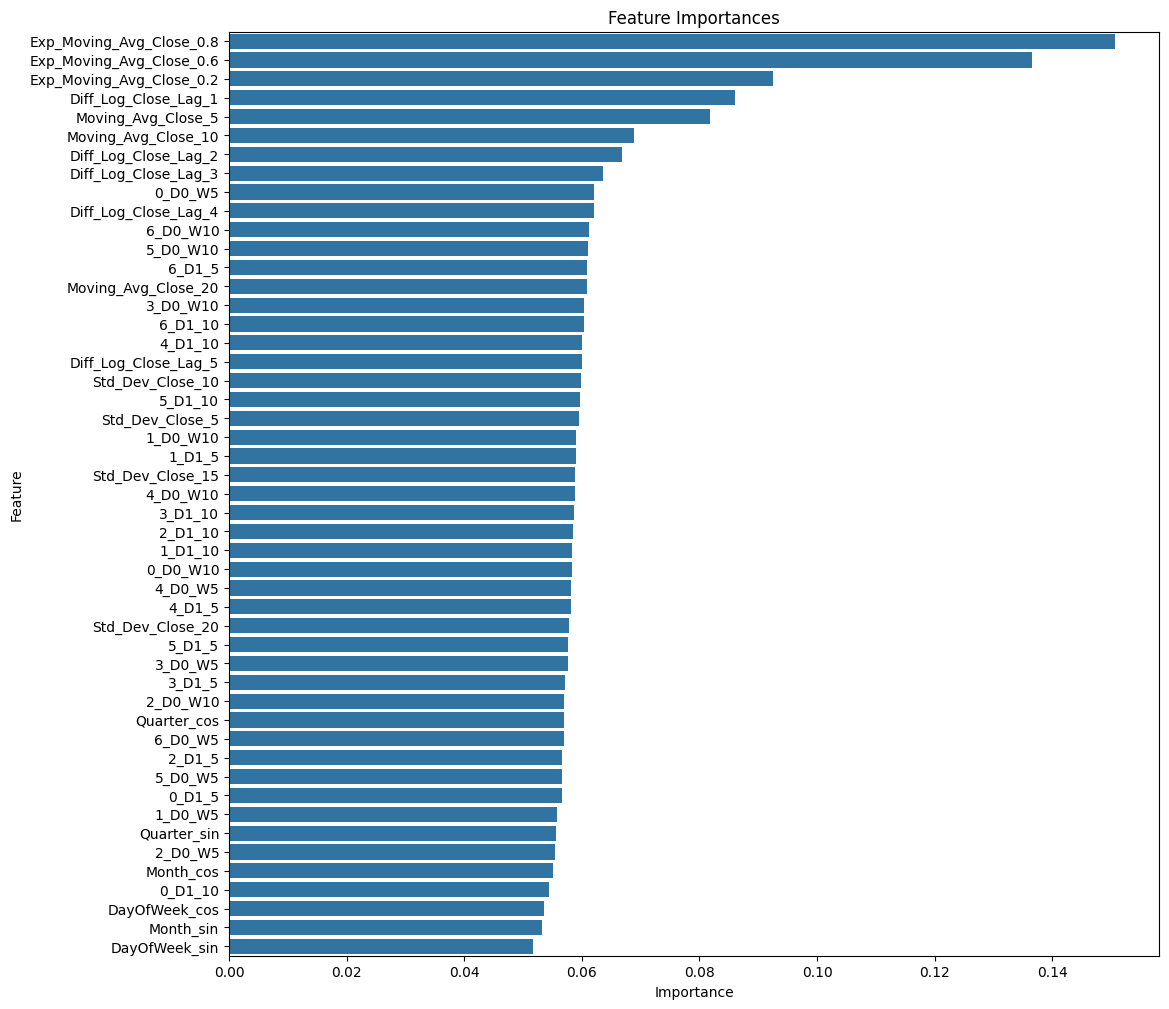

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 12))
sns.barplot(x='Importance', y='Feature', data=importance_df, orient='h', dodge=3.9)  
plt.title('Feature Importances')
plt.show()